In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from korg import InclinedExponentialParameters, InclinedExponentialModel
import korg
import pymfit
from astropy.convolution import convolve
from astropy.io import fits
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use('/Users/jgreco/Dropbox/dotfiles/matplotlib/jpg.mplstyle')

In [2]:
def img_mod_res(img_fn, mod_params, psf_fn=None, cmap='gray_r', 
                axes=None, titles=True, stretch=None, **kwargs):
    """
    Show imfit results: image, model, and residual.
    """

    img = fits.getdata(img_fn)

    if axes is None:
        subplot_kw = dict(xticks=[], yticks=[])
        fig, axes = plt.subplots(1, 3, subplot_kw=subplot_kw, **kwargs)
        fig.subplots_adjust(wspace=0.08)

    s = pymfit.Sersic(mod_params)
    model = s.array(img.shape)

    if psf_fn is not None:
        psf = fits.getdata(psf_fn)
        psf /= psf.sum()
        model = convolve(model, psf)

    res = img - model

    param_labels = {}

    if titles:
        titles = ['Original Image', 'Model', 'Residual']
    else:
        titles = ['']*3

    if stretch is None:
        vmin, vmax = np.percentile(img, [0.1, 99.9])
    else:
        vmin, vmax = stretch

    for i, data in enumerate([img, model, res]):
        axes[i].imshow(data, origin='lower',cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
        axes[i].set_title(titles[i], fontsize=20, y=1.01)

In [3]:
mu_0 = 25
r_e = 5.0
h_over_r = 0.15
PA = 30
sky_sb = 20.5            
m_tot = korg.mu0_to_mtot(mu_0, r_e * u.arcsec, n=1.0)
fwhm_psf = 0.6* u.arcsec
exp_time = 1200*u.s

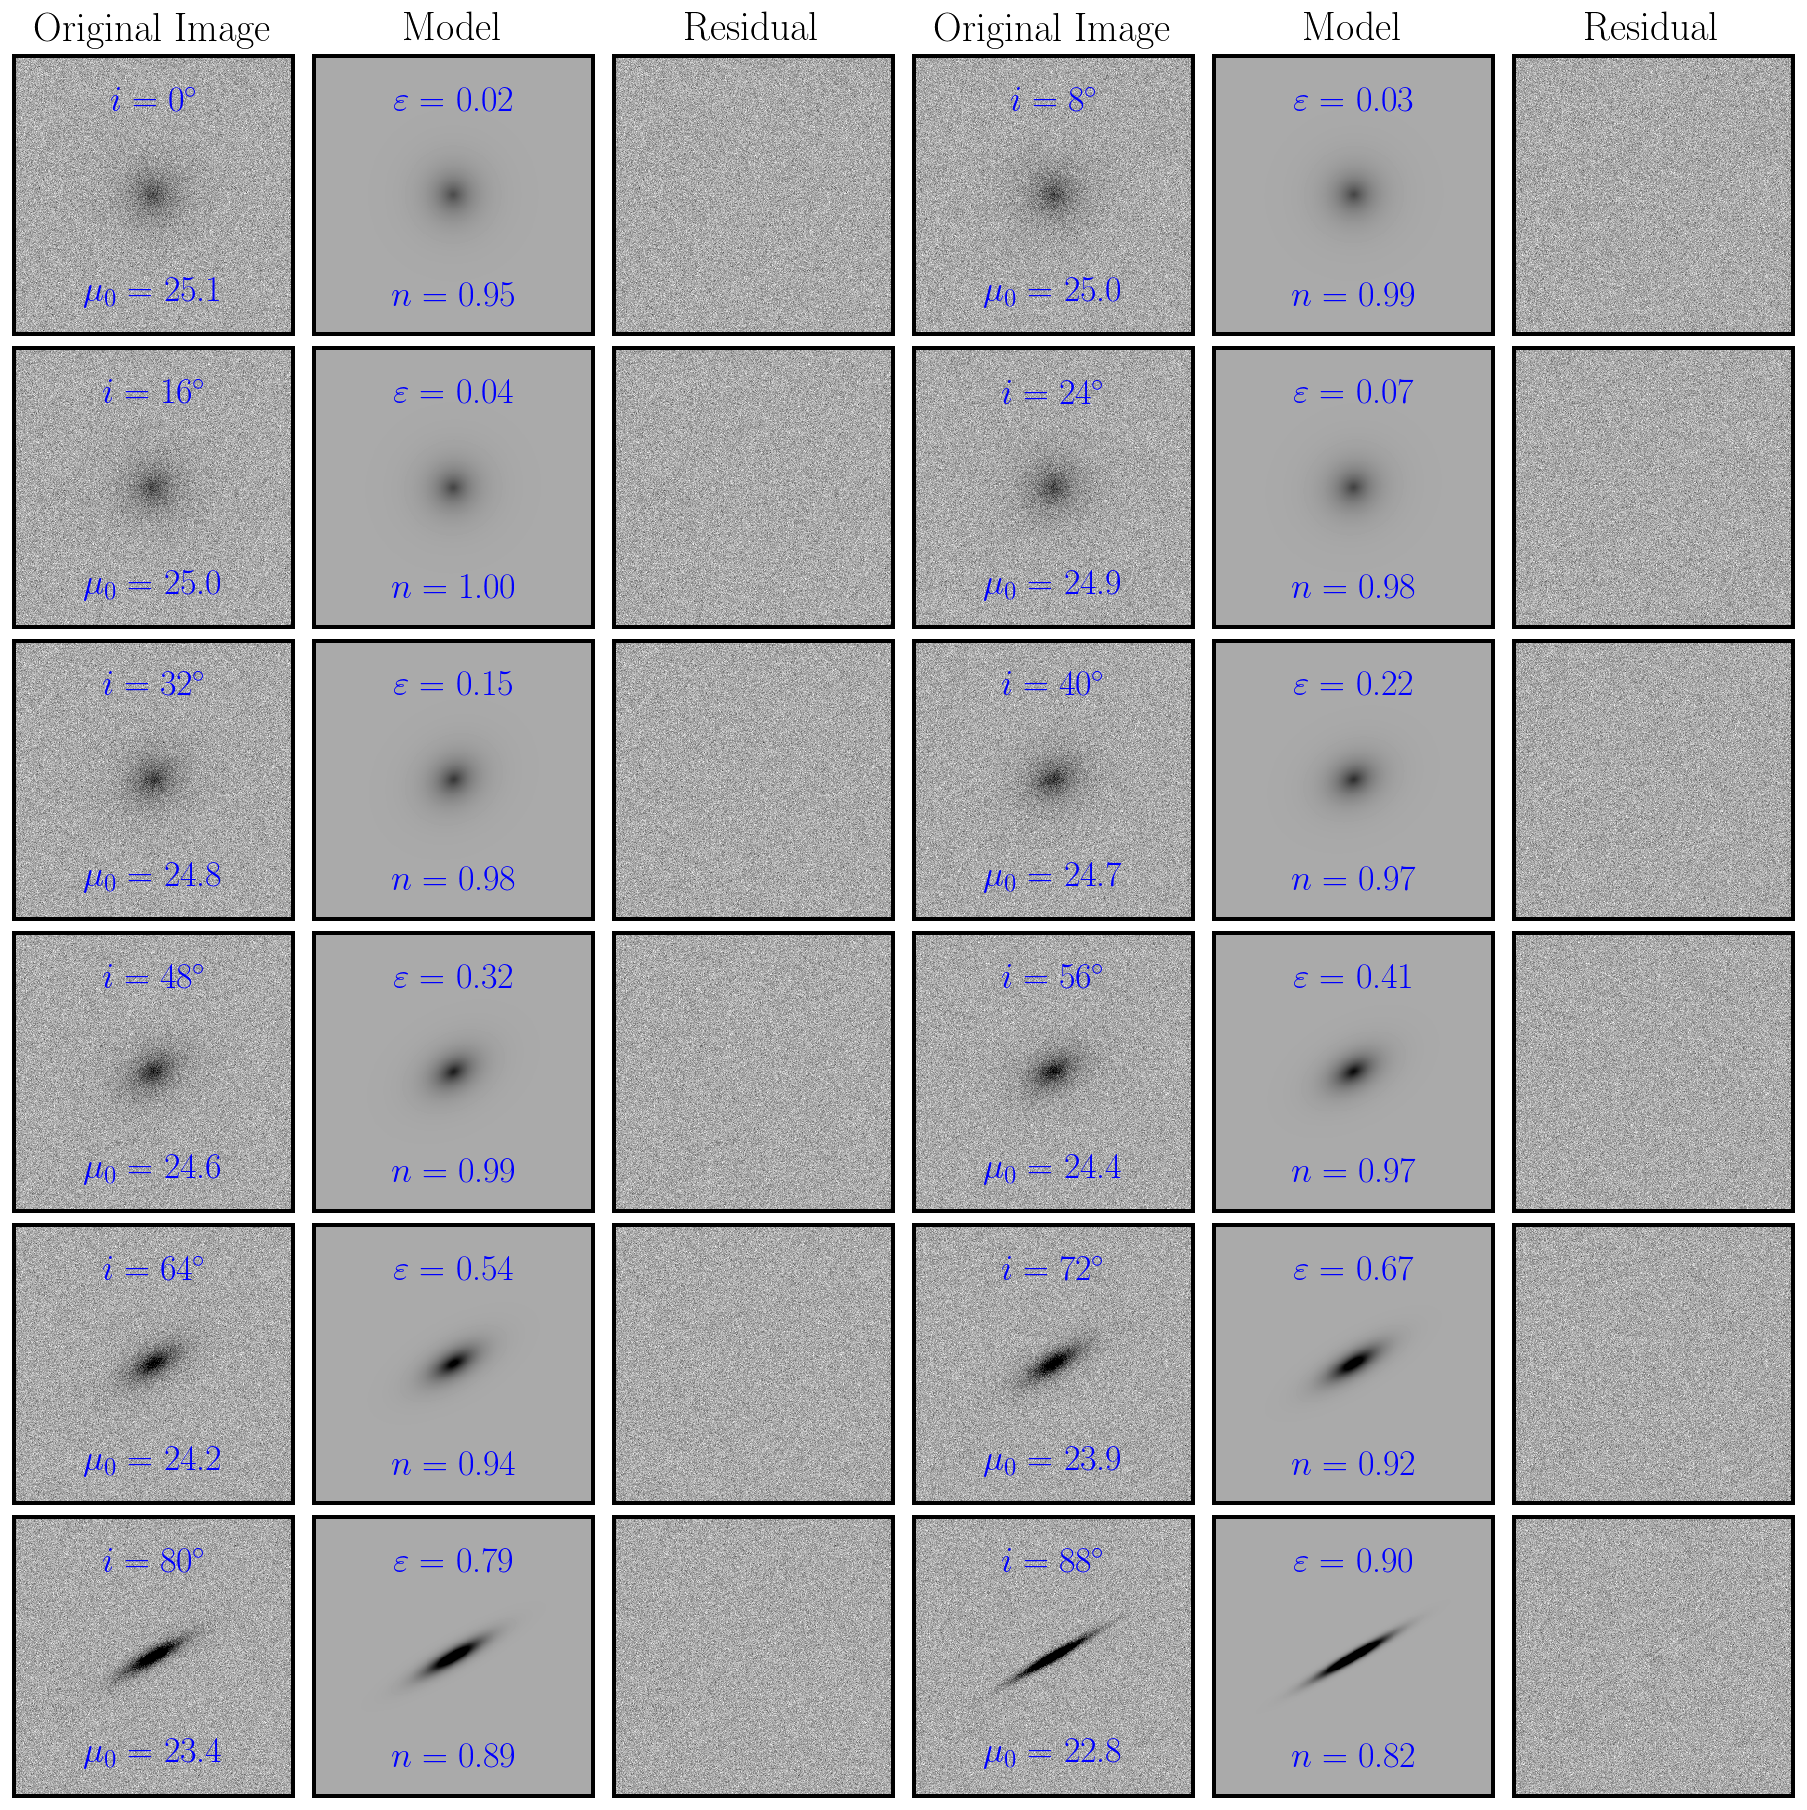

In [4]:
fig, axes = plt.subplots(6, 6, figsize=(16, 16), subplot_kw=dict(xticks=[], yticks=[]))
inclinations = np.linspace(0, 88, 12)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# get stretch
params = InclinedExponentialParameters(m_tot=m_tot, incl=55, r_e=r_e, 
                                       scale_h_over_r=h_over_r, PA=PA)
model = InclinedExponentialModel(params)
model.observe(psf_fwhm=fwhm_psf, sky_sb=sky_sb, exp_time=exp_time)
stretch = np.percentile(model.array, [0.01, 99.99])

i_0 = 0
for row in range(6):
    
    for i in range(2):
        _ax = [axes[row, 3*i], axes[row, 3*i + 1], axes[row, 3*i + 2]]
        incl = inclinations[i_0]
        params = InclinedExponentialParameters(m_tot=m_tot, incl=incl, r_e=r_e, 
                                           scale_h_over_r=h_over_r, PA=PA, exp_time=exp_time)
        model = InclinedExponentialModel(params)
        model.observe(psf_fwhm=fwhm_psf, sky_sb=sky_sb, exp_time=exp_time)
        image_params, sersic_params = korg.fit_disk(model)
        
        titles = True if row==0 else False
        
        img_mod_res('/Users/jgreco/temp-files/model-disk.fits', image_params, axes=_ax,
                    psf_fn='/Users/jgreco/temp-files/psf.fits', titles=titles, stretch=stretch)
        
        x = 0.5
        y_lo = 0.1
        y_hi= 0.8
        ha = 'center'
        
        _ax[0].text(x, y_hi, r'$i=$ {:.0f}$^\circ$'.format(incl), fontsize=18, 
                    ha=ha, transform=_ax[0].transAxes, color='b')
        
        _ax[0].text(x, y_lo, r'$\mu_0=$ {:.1f}'.format(sersic_params['mu_0']), fontsize=18, 
                    ha=ha, transform=_ax[0].transAxes, color='b')

        _ax[1].text(x, y_hi, r'$\varepsilon=$ {:.2f}'.format(sersic_params['ell']), fontsize=18, 
                    ha=ha, transform=_ax[1].transAxes, color='b')
        
        _ax[1].text(x, y_lo, r'$n=$ {:.2f}'.format(sersic_params['n']), fontsize=18, 
                    ha=ha, transform=_ax[1].transAxes, color='b')
        
        i_0 += 1